In [83]:
# Read in dataset to df
import pandas as pd
df = pd.read_csv("../input/creditcard.csv").sample(frac=1)

X = df.drop('Class', axis=1)
y = df['Class']

In [84]:
# Scale Amount and Time in df
from sklearn.preprocessing import RobustScaler

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

X = df.drop('Class', axis=1)
y = df['Class']

In [85]:
# Split data into 80%/20% for train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [43]:
# Grid search on N-neighbors with one fold of data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={ 'n_neighbors': list(range(2, 5)) }, 
    scoring='f1',
    cv=2, 
    verbose=1, 
    n_jobs=-1
)
pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority', random_state=5), knn_grid)
cut = int(len(y_train) * 0.8)
X_small = X_train[:cut]
y_small = y_train[:cut]
pipeline.fit(X_small, y_small)
knn_grid.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.7min finished


{'n_neighbors': 2}

In [86]:
# Train a KNN classifier with 5 fold cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score

knn = KNeighborsClassifier(n_neighbors=2)

cross_val_results = {
    'y_pred': [],
    'y_expect': [],
    'report': []
}

for train_index, test_index in StratifiedKFold(n_splits=5, random_state=5, shuffle=False).split(X_train, y_train):
    # Overfit with SMOTE during cross validation
    curr_X, curr_y = SMOTE(sampling_strategy='minority', random_state=5).fit_resample(X_train[train_index], y_train[train_index])
    knn.fit(curr_X, curr_y)
    
    y_pred = knn.predict(X_train[test_index])
    # Record current training result
    cross_val_results['y_pred'].append(y_pred)
    cross_val_results['y_expect'].append(y_train[test_index])
    cross_val_results['report'].append(classification_report(y_train[test_index], y_pred, output_dict=True))
    
    print('Finished one fold')

Finished one fold
Finished one fold
Finished one fold
Finished one fold
Finished one fold


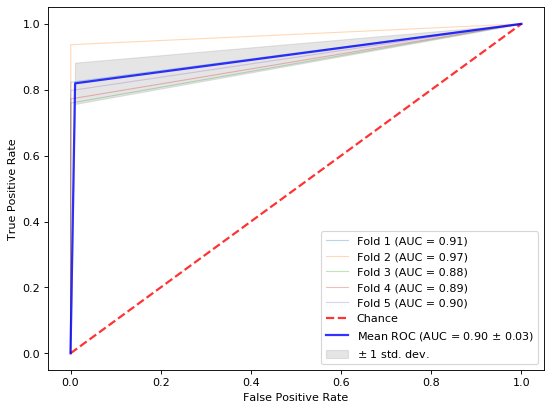

In [87]:
# Plot ROC curve for cross validation
from scipy import interp
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    # Plot ROC curve for current fold
    fpr, tpr, thresholds = roc_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

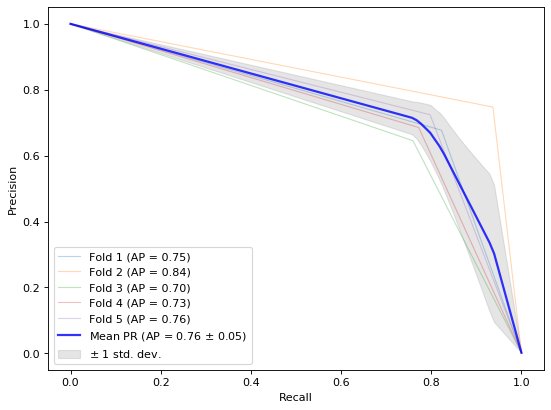

In [88]:
# Plot PR curve for cross validation
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

precisions = []
aps = []
mean_recall = np.linspace(0, 1, 100)

for i in range(5):
    # Plot PR curve for current fold
    precision, recall, _ = precision_recall_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    precisions.append(interp(mean_recall, np.flip(recall), np.flip(precision)))
    ap = auc(recall, precision)
    aps.append(ap)
    plt.plot(recall, precision, lw=1, alpha=0.3, label='Fold %d (AP = %0.2f)' % (i + 1, ap))

mean_precision = np.mean(precisions, axis=0)
mean_ap = auc(mean_recall, mean_precision)
std_auc = np.std(aps)
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_auc), lw=2, alpha=.8)

std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [94]:
# Test the classifier with test dataset
y_pred = knn.predict(X_test)
# Print test report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.66      0.84      0.74        97

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [93]:
# Print mean classification report for cross validation in training
cross_val_mean = { 
    '0': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 }, 
    '1': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'macro avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'weighted avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
}
accuracy = 0

for report in cross_val_results['report']:
    for class_label, metrics in report.items():
        if class_label not in cross_val_mean.keys() and class_label != 'accuracy':
            continue
        if class_label == 'accuracy':
            accuracy += metrics
            continue
        for metric, val in metrics.items():
            cross_val_mean[class_label][metric] += val
            
for class_label, metrics in cross_val_mean.items():
    print('Class:', class_label)
    for metric, val in metrics.items():
        print(metric, val / 5)
print(accuracy / 5)

Class: 0
precision 0.9996833587406012
recall 0.9993800835348428
f1-score 0.9995316957936098
support 45490.0
Class: 1
precision 0.6958501121184221
recall 0.8177215189873419
f1-score 0.7514437712775774
support 79.0
Class: macro avg
precision 0.8477667354295116
recall 0.9085508012610923
f1-score 0.8754877335355935
support 45569.0
Class: weighted avg
precision 0.9991566228788715
recall 0.999065153942373
f1-score 0.9991016019570813
support 45569.0
0.999065153942373
